## **Modelos Generativos.**
### **Generative Adversarial Networks (GANs)

---


Generative Adversarial Networks (GANs) are a type of machine learning model used to generate new data that is similar to the training data. Adversarial Generative Neural Networks are a new way of using deep learning to generate images that look real. They can also generate other types of data such as music.

Specifically, we will work with the **CelebA** dataset, made up of colored faces of celebrities.

<br>
<img src='https://i.imgur.com/h5MtQZ7l.png'>
<br>

---


In [1]:
import os
import gdown
from zipfile import ZipFile

# We download the dataset from the url.
os.makedirs("celeba_gan", exist_ok=True)
url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

# And unzip it...
with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")

In [2]:
from numpy.core.fromnumeric import shape
import tensorflow as tf

from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from tensorflow.keras.optimizers            import SGD
from tensorflow.keras.layers                import *

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

BATCH_SIZE = 8
IMG_SIZE   = (128, 128, 3)

# Load the training images.
train_data = ImageDataGenerator(rescale=1/255).flow_from_directory('/content/celeba_gan/', 
                                                                   class_mode=None, 
                                                                   batch_size=BATCH_SIZE, 
                                                                   target_size=IMG_SIZE[0:2])

Found 202599 images belonging to 1 classes.


((128, 128, 3), 0.0, 1.0)

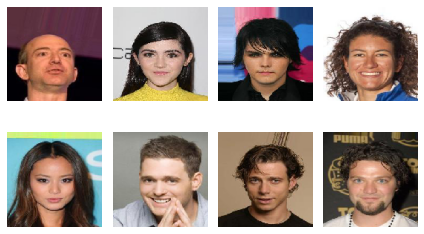

In [3]:
# We display a batch of images from the dataset.
batchX = next(train_data)

fig, axs = plt.subplots(2, 4)

for i in range(8):
  fig.axes[i].imshow(batchX[i])
  fig.axes[i].axis("off")

plt.tight_layout()

# We check that the data is correctly normalized.
(batchX[0].shape, np.min(batchX[0]), np.max(batchX[0]))

In [4]:
def get_discriminator():
  # Create the model discriminator.
  discriminator = Sequential(name="discriminator")

  discriminator.add(Input(shape=(IMG_SIZE)))
  
  discriminator.add(Conv2D(128, kernel_size=4, strides=2, padding="same"))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(alpha=0.2))
  
  discriminator.add(Conv2D(256, kernel_size=4, strides=2, padding="same"))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(alpha=0.2))

  discriminator.add(Conv2D(512, kernel_size=4, strides=2, padding="same"))
  discriminator.add(BatchNormalization())
  discriminator.add(LeakyReLU(alpha=0.2))

  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation="sigmoid"))

  discriminator.summary()
  return discriminator


get_discriminator()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       6272      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       524544    
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 256)      1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 256)     

In [5]:
latent_dim = 128

def get_generator(latent_dim=128):

  generator = Sequential(name="generator")
  generator.add(Input(shape=(latent_dim,)))
  
  generator.add(Dense(4 * 4 * latent_dim))
  generator.add(Reshape((4, 4, latent_dim)))

  generator.add(Conv2DTranspose(128, kernel_size=4, strides=4, padding="same"))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU(alpha=0.2))

  generator.add(Conv2DTranspose(256, kernel_size=4, strides=4, padding="same"))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU(alpha=0.2))
  
  generator.add(Conv2DTranspose(512, kernel_size=4, strides=4, padding="same"))
  generator.add(BatchNormalization())
  generator.add(LeakyReLU(alpha=0.2))

  generator.add(Conv2D(3, kernel_size=5, padding="same", strides=2, activation="sigmoid"))

  generator.summary()
  return generator

get_generator()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2048)              264192    
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 256)      52

In [6]:
class GAN(tf.keras.Model):

  def __init__(self, discriminator, generator, latent_dim):
      super(GAN, self).__init__()
      # We save the discriminator and the generator.
      self.discriminator = discriminator
      self.generator     = generator
      self.latent_dim    = latent_dim

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile(d_optimizer, g_optimizer, loss_fn)
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn
  
  def train_step(self, real_images):

    # ----------- DETECTOR TRAINING ------------- #

    # Lot Size.
    batch_size = tf.shape(real_images)[0]

    # We generate random vectors as input to the generating network.
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

    # We use the vectors to generate random images. (We decode)
    fake_images = self.generator(random_latent_vectors)

    # We generate the output for each image (Fake: 1 / Real: 0)
    combined_images = tf.concat([fake_images, real_images], axis=0)

    # We generate the output for each image (Fake: 1 / Real: 0)
    labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

    # Add noise to labels - Important tip! (F.Chollet)
    # We can also add a Dropout layer in the discriminator.
    labels += 0.05 * tf.random.uniform(tf.shape(labels))

    with tf.GradientTape() as tape:

      # Predictions made by the discriminator.
      predictions = self.discriminator(combined_images)

      # We evaluate the results of the discriminator with the cost function.
      d_loss = self.loss_fn(labels, predictions)

    # Calculate the gradient with the discriminator error.
    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)

    # Update the parameters with the gradients.
    self.d_optimizer.apply_gradients(
          zip(grads, self.discriminator.trainable_weights)
      )
    

    # ----------- GENERATOR TRAINING ------------- #

     # We create new vectors to generate random images. (We decode)
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

    # We create the labels with which to supervise the training of the generator.
    misleading_labels = tf.zeros((batch_size, 1))

    # We train the generator WITHOUT updating the detector!
    with tf.GradientTape() as tape:
      
      # We obtain new predictions by passing to the discriminator what is generated.
      predictions = self.discriminator(self.generator(random_latent_vectors))

      # We calculate the error of the generator in its task of confusing the discriminator.
      g_loss = self.loss_fn(misleading_labels, predictions)

    # Calculate the gradient of the generator.
    grads = tape.gradient(g_loss, self.generator.trainable_weights)

    # Update the parameters with the gradients.
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

    return {}

In [7]:
from tensorflow.keras.callbacks import Callback

# We create a custom callback to visualize the evolution
# of the generator after each epoch.
class GANMonitor(Callback):

    def on_epoch_end(self, epoch, logs=None):
      
        random_latent_vectors = tf.random.normal(shape=(1, self.model.latent_dim))
        generated_image = self.model.generator(random_latent_vectors)
        if generated_image.shape[3] > 1:
          plt.imshow(generated_image[0,:,:,:])
        else:
          plt.matshow(generated_image[0,:,:,0])
        plt.show()

In [9]:
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *

# We create a GAN with our class.
gan = GAN(discriminator=get_discriminator(), generator=get_generator(), latent_dim=latent_dim)

# We configure the optimizers of each part...
gan.compile(d_optimizer=Adam(learning_rate=0.0001),
            g_optimizer=Adam(learning_rate=0.0001),
            loss_fn=BinaryCrossentropy())



Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 128)       6272      
                                                                 
 batch_normalization_12 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 256)       524544    
                                                                 
 batch_normalization_13 (Bat  (None, 32, 32, 256)      1024      
 chNormalization)                                                
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 32, 32, 256)     

In [ ]:
gan.fit(train_data, epochs=1000, callbacks=[GANMonitor()], batch_size=BATCH_SIZE, steps_per_epoch=100)

Epoch 1/1000
  1/100 [..............................] - ETA: 6:29